通过多项式拟合交互地探索这些概念

In [10]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

使用三阶多项式来生成训练和测试数据集的标签：

$y = 5 + 1.2x - 3.4{\frac {x^2} {2!}} + {5.6\frac {x^3} {3!}} + \epsilon ~ where ~ \epsilon \sim N(0, 0.1^2)$

In [35]:
max_degree = 20 # 特征数为 20，除了前 4 个特征，后面的特征都是 0
n_train, n_test = 100, 100 # 训练和测试样本都为 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([100, 1.9, -2.4, 8.6]) # 前 4 个特征有数值

features = np.random.normal(size=(n_train + n_test, 1)) # 生成大小为 200 * 1 的特征数组，就是样本数为 200
np.random.shuffle(features) # 打乱特征顺序
""" np.arange(max_degree).reshape(1, -1)，将 200 * 1 的特征每一行的 x 分别进行递增的 20 次指数运算，变成 1, x, x^2,...,x^19 """
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # power(x, y) 以 x 数组为底，y数组为指数运算
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # poly_features[:, i] 指对每一行的递增列进行运算，gamma(i) = (i - 1)!
labels = np.dot(poly_features, true_w) # labels = y = 200 * 1
labels += np.random.normal(scale=0.1, size=labels.shape) # 加上噪音

把 `NumPy ndarray` 转换为 `tensor`

In [36]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

### 评估模型在给定数据集上的损失

In [13]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y) # y是真实值，out 是预测
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1] # 总损失 / 总数，得到平均损失

### 训练

定义训练函数

In [40]:
def train(train_features, test_features, train_lables, test_labels, num_epochs = 400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # 定义线性回归网络（ 1 层）
    batch_size = min(10, train_lables.shape[0])
    train_iter = d2l.load_array((train_features, train_lables.reshape(-1, 1)), batch_size) # 创建训练数据迭代器
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)# 创建测试数据迭代器
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0: # 每20个epoch记录并可视化一次训练损失和测试损失 
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy()) # weight 即权重，就是自变量的系数，也就是 w，也就是学习出的东西

训练过程1，这里的情况比较好，没有加入噪音去训练，只用了数据的前 4 列训练，即没有噪音的部分

weight: [[100.006294    1.9022481  -2.3777373   8.555569 ]]


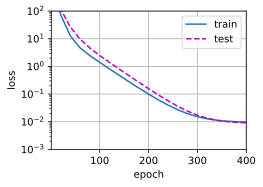

In [25]:
train(poly_features[:n_train, :4], poly_features[n_test:, :4], labels[:n_train], labels[n_test:]) # 训练数据取前 100，测试数据后 100

训练过程2，只是用前 2 列特征训练，模型容量不够，就会欠拟合

weight: [[98.65337  5.97792]]


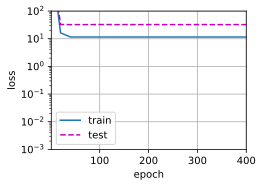

In [28]:
train(poly_features[:n_train, :2], poly_features[n_test:, :2], labels[:n_train], labels[n_test:])

训练过程3，模型容量过大 (参数过多，但参数包含噪音，实际上只应该训练前 4 个)，导致过拟合，实际上在 200 次之前已经拟合的很好了，但是由于学习了噪声（噪声的权重应该是 0），导致迭代次数变大后拟合不好

weight: [[ 9.9944283e+01  2.1169279e+00 -1.9431468e+00  7.9747510e+00
  -1.9839723e+00 -3.1588966e-01  1.2595578e+00 -6.4735574e-01
   4.5514238e-01 -3.4144863e-01  1.5196371e-02 -8.4978789e-02
  -2.5797529e-02  1.7953484e-01  1.7494956e-01 -1.7238650e-01
   1.2258139e-01  2.0210609e-01 -2.9041465e-02  1.1174868e-01]]


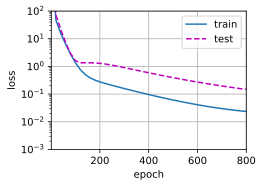

In [38]:
train(poly_features[:n_train, :], poly_features[n_test:, :], labels[:n_train], labels[n_test:])

### 代码撰写总结
1. 训练和测试数据集，得到 `features` 和 `labels`，若是自己编写数据集，则需要 `true_w` 用于生成 `labels`
2. 定义训练网络，使用 `torch.nn.Sequential()` 添加层次，这一步网络的输出就是 `trained_labels`，还要定义一个函数以对每一连接层赋初始权重
3. 定义损失函数，使用 `torch.nn.MSELoss()` 或 `torch.nn.CrossEntropyLoss()`，即真实标签和训练标签的损失
4. 定义优化函数，一般使用 `torch.nn.optim.SGD()`，这一步更新所需的权重
5. 定义训练函数，注意使用 `SGD` 优化函数更新权重之前要求导
6. 画图